In [2]:
from typing import TypedDict, Annotated
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
#from langchain_community.tools import searc

In [3]:
from dotenv import load_dotenv
import os
load_dotenv
groq_api_key : str = os.environ.get("GROQ_API_KEY")

In [4]:
class State(TypedDict):
    messages : Annotated[list, add_messages]

In [5]:
llm = ChatGroq(
    groq_api_key = groq_api_key,
    model="deepseek-r1-distill-llama-70b"
)

#response = llm.invoke("what can you do for me")
#print(response.content)

In [6]:
# Tool 1: Get stock price
@tool
def get_stock_price(symbol: str) -> float:
    ''' 
    Return the current price of a stock symbol.
    :param symbol: Stock symbol (e.g., "AAPL", "GOOGL").
    :return: Current price of the stock as a float.
    '''
    return {
        "AAPL": 175.32,
        "GOOGL": 2850.45,
        "AMZN": 143.67,
        "MSFT": 330.12,
        "TSLA": 255.78,
        "META": 312.56,
        "NFLX": 410.23,
        "NVDA": 480.99,
        "IBM": 135.67,
        "ORCL": 123.45
    }.get(symbol.upper(), 0.0)

# Tool 2: Convert currency
@tool
def convert_currency(amount: float, from_currency: str, to_currency: str) -> float:
    ''' 
    Convert an amount from one currency to another.
    :param amount: The amount to convert.
    :param from_currency: The currency to convert from (e.g., "USD").
    :param to_currency: The currency to convert to (e.g., "EUR").
    :return: The converted amount as a float.
    '''
    exchange_rates = {
        ("USD", "EUR"): 0.85,
        ("EUR", "USD"): 1.18,
        ("USD", "GBP"): 0.75,
        ("GBP", "USD"): 1.33,
    }
    return amount * exchange_rates.get((from_currency.upper(), to_currency.upper()), 1.0)

# Tool 3: Get weather information
@tool
def get_weather(city: str) -> str:
    ''' 
    Get the current weather information for a city.
    :param city: The name of the city (e.g., "New York").
    :return: A string describing the weather (e.g., "Sunny, 25°C").
    '''
    weather_data = {
        "New York": "Sunny, 25°C",
        "London": "Cloudy, 18°C",
        "Paris": "Rainy, 20°C",
        "Tokyo": "Clear, 30°C",
    }
    return weather_data.get(city, "Weather data not available")

# Tool 4: Calculate factorial
@tool
def calculate_factorial(n: int) -> int:
    ''' 
    Calculate the factorial of a number.
    :param n: The number to calculate the factorial for.
    :return: The factorial of the number as an integer.
    '''
    if n == 0:
        return 1
    factorial = 1
    for i in range(1, n + 1):
        factorial *= i
    return factorial

# Define the tools list
tools = [get_stock_price, convert_currency, get_weather, calculate_factorial]

In [7]:
llmtools = llm.bind_tools(tools)

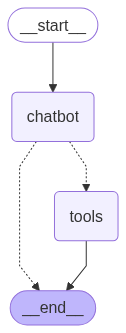

In [14]:
def chatbot(state: State) -> State:
    return {"messages": [llmtools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START,"chatbot")
builder.add_conditional_edges("chatbot",tools_condition)

graph = builder.compile()

from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
state = graph.invoke({"messages": {"What is the price of GOOGL shares?"}})
print(state["messages"][-1])

InvalidUpdateError: Expected dict, got {'What is the price of GOOGL shares?'}
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE